In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re

from collections import Counter
from unidecode import unidecode as decode

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# EDA and Reduce

Dataset obtained from: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset/data

In [2]:
root = os.environ['HOME'] + "/Scripts"
data = pd.read_csv(f"{root}/spam.csv", encoding="ISO-8859-1")

data.drop(data.columns.to_list()[2:], axis=1, inplace=True)
data

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [3]:
print('duplicate SMS: ', data['v2'].duplicated().sum())

duplicate SMS:  403


In [4]:
duped = pd.DataFrame(columns=['SMS', 'duplicates'])

dupes = Counter(data['v2'][data['v2'].duplicated()])
duped['SMS']        = dupes.keys()
duped['duplicates'] = dupes.values()

data['v2'].drop_duplicates()
duped

,SMS,duplicates
0,As per your request 'Melle Melle (Oru Minnamin...,2
1,"As I entered my cabin my PA said, '' Happy B'd...",2
2,"Sorry, I'll call later",29
3,No calls..messages..missed calls,2
4,Congratulations ur awarded 500 of CD vouchers ...,1
...,...,...
276,K. I will sent it again,2
277,"SMS SERVICES. for your inclusive text credits,...",1
278,I went to project centre,1
279,You are awarded a SiPix Digital Camera! call 0...,1


Text(0.5, 1.0, 'Count')

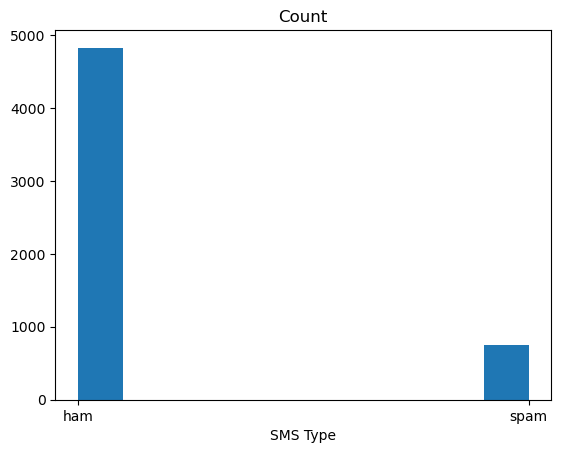

In [5]:
plt.hist(data['v1'])
plt.xlabel('SMS Type')
plt.title('Count')

In [6]:
x_data = data['v2'].to_list()
y_data = data['v1'].to_list()

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [7]:
x_train = pd.DataFrame(x_train, columns=['SMS'])
y_train = pd.Series(y_train)

x_test  = pd.DataFrame(x_test, columns=['SMS'])
y_test  = pd.Series(y_test)
x_train

,SMS
0,No I'm in the same boat. Still here at my moms...
1,(Bank of Granite issues Strong-Buy) EXPLOSIVE ...
2,They r giving a second chance to rahul dengra.
3,O i played smash bros &lt;#&gt; religiously.
4,PRIVATE! Your 2003 Account Statement for 07973...
...,...
4452,I came hostel. I m going to sleep. Plz call me...
4453,"Sorry, I'll call later"
4454,Prabha..i'm soryda..realy..frm heart i'm sory
4455,Nt joking seriously i told


In [8]:
all_words = {}
top_100   = {}

for sms in x_train['SMS']:
    for word in sms.split(' '):
        if word in all_words.keys(): all_words[word] += 1
        else:                        all_words[word]  = 1

all_words = dict(sorted(all_words.items(), key=lambda item: item[1], reverse=True))

for i, key in enumerate(all_words.keys()):
    if i < 30 or i > 129: ## omit top 30 common
        continue
    top_100[key] = all_words[key]

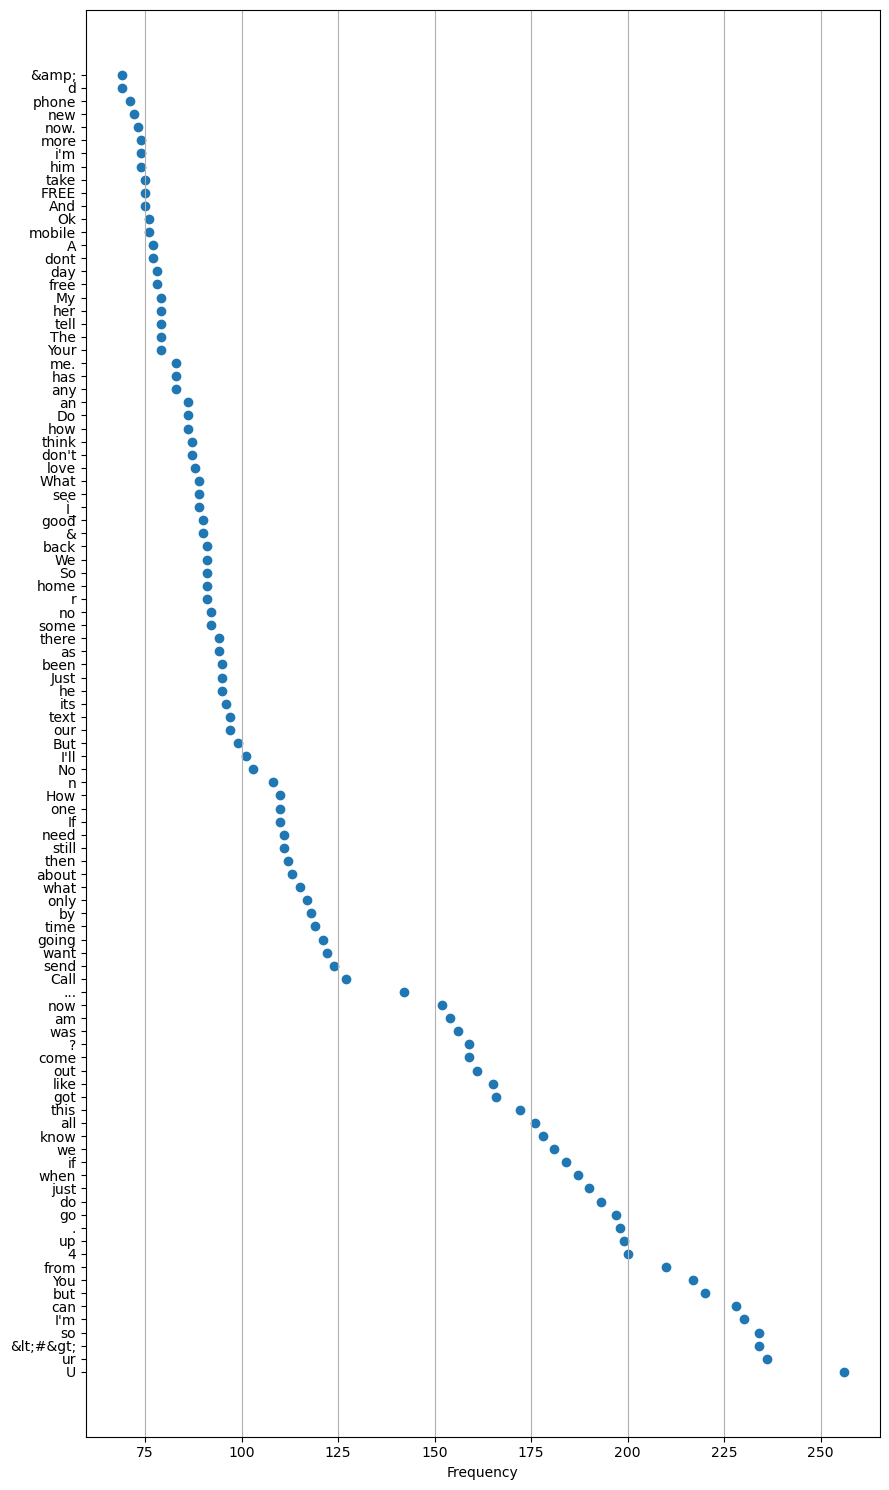

In [9]:
plt.figure(figsize=(9, 15))
plt.scatter(top_100.values(), top_100.keys())
plt.xlabel('Frequency')
plt.grid(axis='x')
plt.tight_layout()

Looking at total number of messages, the dataset isn't particularly well-balanced between the number of spam and non-spam (ham) messages.

Based on first impressions, the text messages look like they're from when SMS was first introduced to phones. It contains lots of colloquial abbreviations and numbers. There's also uneven spacing and additional symbols that may be a part of the SMS itself or characters created during the decoding of the data. All these elements will need to be removed prior to modeling. 

I then tokenized and lemmatized the text to make model-training easier.

In [10]:
def reduce(data):
    tokenized = []
    for article in data:
        redux = re.sub(' +', ' ', article)
        redux = re.sub(r'[^\w\s]+', ' ', redux)
        redux = re.sub(r'[0-9]+', '', redux)
        redux = decode(redux).lower()

        lemmatize = [WordNetLemmatizer().lemmatize(token) for token in word_tokenize(redux)]
        tokenized.append(' '.join(lemmatize))
    return tokenized

In [11]:
x_train['Tokenized'] = reduce(x_train['SMS'])
x_test['Tokenized']  = reduce(x_test['SMS'])
x_train

,SMS,Tokenized
0,No I'm in the same boat. Still here at my moms...,no i m in the same boat still here at my mom c...
1,(Bank of Granite issues Strong-Buy) EXPLOSIVE ...,bank of granite issue strong buy explosive pic...
2,They r giving a second chance to rahul dengra.,they r giving a second chance to rahul dengra
3,O i played smash bros &lt;#&gt; religiously.,o i played smash bros lt gt religiously
4,PRIVATE! Your 2003 Account Statement for 07973...,private your account statement for show un red...
...,...,...
4452,I came hostel. I m going to sleep. Plz call me...,i came hostel i m going to sleep plz call me u...
4453,"Sorry, I'll call later",sorry i ll call later
4454,Prabha..i'm soryda..realy..frm heart i'm sory,prabha i m soryda realy frm heart i m sory
4455,Nt joking seriously i told,nt joking seriously i told


# Unsupervised Model

In [12]:
def best_guess(df, y, true):
    best_match = 0 
    categories = {cat : '' for cat in ['ham', 'spam']}
    
    for combo in itertools.permutations(range(2)):
        for c, cat in zip(combo, categories.keys()):
            categories[cat] = c

        prediction = y.map(categories)
        accuracy   = accuracy_score(true, prediction)
        if accuracy > best_match: 
            best_match = accuracy
            best_cat   = combo
    return best_match, best_cat

In [13]:
def all_guesses(df, y, tdf_model, nmf_model):
    tdf_train = tdf_model.fit_transform(df['Tokenized'])
    nmf_train = nmf_model.fit_transform(tdf_train)
    
    nmf_train = np.argsort(nmf_train)
    all_guess = [nmf_train[i][nmf_train.shape[1] - 1] for i in range(nmf_train.shape[0])]
    return best_guess(df, y, all_guess)

A grid search of the best parameters was run for both models. To find the best parameters for the TF-IDF matrix was computed by using default parameters for the NMF model and vice versa to find the best parameters for the NMF.

In [14]:
max_df_params       = np.arange(0.1, 1.1, .25)
min_df_params       = np.arange(0, 1, .25)
norm_params         = ['l1', 'l2']
use_idf_params      = [True, False]
smooth_idf_params   = [True, False]
sublinear_tf_params = [True, False]

best_acc_1 = 0
for max_df in max_df_params:
    for min_df in min_df_params:
        for norm in norm_params:
            for use_idf in use_idf_params:
                for smooth_idf in smooth_idf_params:
                    for sublinear_tf in sublinear_tf_params:
                        
                        tdf_model = TfidfVectorizer(stop_words   = 'english',
                                                    ngram_range  = (1, 1),
                                                    max_df       = max_df,
                                                    min_df       = min_df,
                                                    norm         = norm,
                                                    use_idf      = use_idf,
                                                    smooth_idf   = smooth_idf,
                                                    sublinear_tf = sublinear_tf)
                        
                        nmf_model = NMF(n_components = 5, random_state = 42)

                        try:    acc, order = all_guesses(x_train, y_train, tdf_model, nmf_model)
                        except: continue
                        
                        if acc > best_acc_1:
                            best_acc_1 = acc
                            best_ord_1 = order
                            best_pms_1 = max_df, min_df, norm, use_idf, smooth_idf, sublinear_tf

In [15]:
print('best vec results')
print('accuracy :', best_acc_1)
print('labels   :', best_ord_1)
print('params   :', best_pms_1)

best vec results
accuracy : 0.4029616333856854
labels   : (0, 1)
params   : (0.1, 0.0, 'l2', False, True, True)


In [16]:
n_comp_params    = [1, 3, 5, 10]
init_params      = ['random', 'nndsvd', 'nndsvda', 'nndsvdar']
solver_params    = ['cd', 'mu']
beta_loss_params = ['frobenius', 'kullback-leibler', 'itakura-saito']
max_iter_params  = [50, 100, 500, 1000]
l1_ratio_params  = np.arange(0, 1.1, .25)

best_acc_2 = 0
for n_comps in n_comp_params:
    for init in init_params:
        for solver in solver_params:
            for beta_loss in beta_loss_params:
                for max_iter in max_iter_params:
                    for l1_ratio in l1_ratio_params:

                        tdf_model = TfidfVectorizer(stop_words = 'english')
                        
                        nmf_model = NMF(n_components = n_comps,
                                  init         = init,
                                  solver       = solver,
                                  beta_loss    = beta_loss,
                                  max_iter     = max_iter,
                                  random_state = 42,
                                  l1_ratio     = l1_ratio)

                        try:    acc, order = all_guesses(x_train, y_train, tdf_model, nmf_model)
                        except: continue

                        if acc > best_acc_2:
                            best_acc_2 = acc
                            best_ord_2 = order
                            best_pms_2 = n_comps, init, solver, beta_loss, max_iter, l1_ratio

/Users/saravi/Software/miniforge3/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1561: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(
/Users/saravi/Software/miniforge3/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1561: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(
/Users/saravi/Software/miniforge3/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1561: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nnds

In [17]:
print('best nmf results')
print('accuracy :', best_acc_2)
print('labels   :', best_ord_2)
print('params   :', best_pms_2)

best nmf results
accuracy : 0.8660533991474085
labels   : (0, 1)
params   : (1, 'random', 'cd', 'frobenius', 50, 0.0)


In [18]:
tdf_model = TfidfVectorizer(stop_words   = 'english',
                            ngram_range  = (1, 1),
                            max_df       = 0.1,
                            min_df       = 0.0,
                            norm         = 'l2',
                            use_idf      = False,
                            smooth_idf   = True,
                            sublinear_tf = True)

nmf_model = NMF(n_components = 1,
                init         = 'random',
                solver       = 'cd',
                beta_loss    = 'frobenius',
                max_iter     = 50,
                random_state = 42,
                l1_ratio     = 0.0,
                shuffle      = True)

In [19]:
best_acc, best_order = all_guesses(x_train, y_train, tdf_model, nmf_model)
best_categories      = {cat : order for order, cat in zip(best_order, ['ham', 'spam'])}

print('accuracy:', best_acc)
print('category:', best_categories)

accuracy: 0.8660533991474085
category: {'ham': 0, 'spam': 1}


In [20]:
tdf_test = tdf_model.transform(x_test['Tokenized'])
nmf_test = nmf_model.transform(tdf_test)
nmf_test = np.argsort(nmf_test)

predicts = [nmf_test[i][nmf_test.shape[1] - 1] for i in range(nmf_test.shape[0])]
results  = [k for pred in predicts for k, v in best_categories.items() if v == pred]

In [21]:
accuracy_score(y_test.to_list(), results)

0.8654708520179372

With the best parameters found for each model, the accuracy of the training and test data is found to be 86.6% and 86.5%, respectively. 

The accuracies closely matching suggests the model was able to generalize over the training data without overfitting which, in turn, suggests that the model was essentially able to learn the difference between real and spam text messages with a good level of accuracy.

But it must be noted that the quality of this data isn't quite representative of real-world spam text messages. And the availability (or lack thereof) of enough spam messages could have indirectly biased the model into simply predicting all messages are not spam and therefore, similar to how a broken clock is right twice a day, this model would simply have a good accuracy due to there being more non-spam than spam messages.

# Supervised Model

A similar approach to the unsupervised model was taken whereby a grid search was performed to find the best parameters for the chosen supervised model (KMeans).

In [22]:
n_cluster_params = [2, 4, 8, 16]
init_params      = ['k-means++', 'random']
n_init_params    = ['auto', 1, 3, 5]
max_iter_params  = [50, 100, 500, 1000]
algorithm_params = ['lloyd', 'elkan']

best_acc_3 = 0
for n_clusters in n_cluster_params:
    for init in init_params:
        for n_init in n_init_params:
            for max_iter in max_iter_params:
                for algorithm in algorithm_params:

                    tdf_model  = TfidfVectorizer(stop_words = 'english')
                    
                    kmn_model  = KMeans(n_clusters = n_clusters,
                                        init       = init,
                                        n_init     = n_init,
                                        max_iter   = max_iter,
                                        algorithm  = algorithm)

                    
                    tdf_train  = tdf_model.fit_transform(x_train['Tokenized'])
                    predicts   = kmn_model.fit_predict(tdf_train)

                    try:    acc, order = best_guess(x_train, y_train, predicts)
                    except: continue

                    if acc > best_acc_3:
                        best_acc_3 = acc
                        best_ord_3 = order
                        best_pms_3 = n_clusters, init, n_init, max_iter, algorithm

In [23]:
print('best kmeans results')
print('accuracy :', best_acc_3)
print('labels   :', best_ord_3)
print('params   :', best_pms_3)

best kmeans results
accuracy : 0.9463764864258469
labels   : (0, 1)
params   : (2, 'random', 3, 50, 'lloyd')


In [24]:
tdf_model = TfidfVectorizer(stop_words   = 'english',
                            ngram_range  = (1, 1),
                            max_df       = 0.1,
                            min_df       = 0.0,
                            norm         = 'l2',
                            use_idf      = False,
                            smooth_idf   = True,
                            sublinear_tf = True)

kmn_model = KMeans(n_clusters = 2,
                   init       = 'k-means++',
                   n_init     = 'auto',
                   max_iter   = 100,
                   algorithm  = 'lloyd')

In [25]:
tdf_train  = tdf_model.fit_transform(x_train['Tokenized'])
pred_train = kmn_model.fit_predict(tdf_train)

best_acc, best_order = best_guess(x_train, y_train, pred_train)
print('accuracy    :', best_acc)
print('label order :', best_order)

accuracy    : 0.8267893201705183
label order : (1, 0)


In [26]:
tdf_test  = tdf_model.fit_transform(x_test['Tokenized'])
pred_test = kmn_model.fit_predict(tdf_test)

In [27]:
results = [k for pred in pred_test for k, v in best_categories.items() if v == pred]

accuracy_score(y_test.to_list(), results)

0.7874439461883408

Using a supervised learning approach performs similarly to the unsupervised learning approach when considering the training data (86.6% vs. 82.7%). However, the test accuracy is notably worse (86.5% vs. 78.7%).

More powerful and stringent supervised learning models may improve the accuracy but this suggests that these types of classification tasks peform much better with labeled data. Since the test accuracy is lower, it means the model didn't simply predict a binary 'all spam' or 'all non-spam' outcome and it was able to, at least, partially identify spam messages.